In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
import torch

# 데이터 읽기
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sd = pd.read_csv('data/submission_sample.csv')

# 결측치 확인 및 제거
train = train.dropna(subset=['revenue1'])
train = train.fillna(0)
# 'open'을 1로, 'close'를 0으로 변환
train['OC'] = train['OC'].map({'open': 1, 'close': 0})


# 문자열에서 "," 제거하고 float으로 변환한 후 결측치와 무한대 값을 처리
train['employee1'] = np.nan_to_num(train['employee1'].apply(lambda x: str(x).replace(',', '')).astype(float)).astype(int)
train['employee2'] = np.nan_to_num(train['employee2'].apply(lambda x: str(x).replace(',', '')).astype(float)).astype(int)
test['employee1'] = np.nan_to_num(test['employee1'].apply(lambda x: str(x).replace(',', '')).astype(float)).astype(int)
test['employee2'] = np.nan_to_num(test['employee2'].apply(lambda x: str(x).replace(',', '')).astype(float)).astype(int)



# 범주형 변수를 숫자로 변환
train['sido'] = train['sido'].astype('category').cat.codes
test['sido'] = test['sido'].astype('category').cat.codes
train['instkind'] = train['instkind'].astype('category').cat.codes
test['instkind'] = test['instkind'].astype('category').cat.codes
train['ownerChange'] = train['ownerChange'].astype('category').cat.codes
test['ownerChange'] = test['ownerChange'].astype('category').cat.codes

train = train.fillna(0)
# 모델 훈련
X = train.drop(['OC'], axis=1)
y = train['OC']

data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 10, alpha = 10, n_estimators = 2000)
xg_reg.fit(X_train,y_train)
y_pred_proba = xg_reg.predict(X_test)
y_pred_proba_tensor = torch.from_numpy(y_pred_proba)
y_pred_proba_tensor = torch.sigmoid(y_pred_proba_tensor)
y_pred_proba = y_pred_proba_tensor.numpy()

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, average_precision_score

best_threshold = 0
best_score = 0
best_metrics = {}

for threshold in np.arange(0, 1.001, 0.001):  # 0부터 1까지 0.001 간격으로
    y_pred = (y_pred_proba >= threshold).astype('int')  # 확률이 threshold 이상이면 클래스 1로, 그렇지 않으면 0으로 판단
    score = roc_auc_score(y_test, y_pred)  # ROC AUC 점수 계산
    if score > best_score:  # 이전보다 더 좋은 점수인 경우 업데이트
        best_score = score
        best_threshold = threshold
        best_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
        best_metrics['F1 Score'] = f1_score(y_test, y_pred)
        best_metrics['Precision'] = precision_score(y_test, y_pred)
        best_metrics['Recall'] = recall_score(y_test, y_pred)
        best_metrics['PR AUC'] = average_precision_score(y_test, y_pred)

print("Best Threshold: ", best_threshold)
print("Best ROC AUC Score: ", best_score)
print("At this threshold:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value}")



[08:46:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Best Threshold:  0.6990000000000001
Best ROC AUC Score:  0.9736842105263157
At this threshold:
Accuracy: 0.9491525423728814
F1 Score: 0.972972972972973
Precision: 1.0
Recall: 0.9473684210526315
PR AUC: 0.9982158786797503


In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
import torch

# 데이터 읽기
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sd = pd.read_csv('data/submission_sample.csv')

# 결측치 확인 및 제거
train = train.dropna(subset=['revenue1'])
train = train.fillna(0)
# 'open'을 1로, 'close'를 0으로 변환
train['OC'] = train['OC'].map({'open': 1, 'close': 0})


# 문자열에서 "," 제거하고 float으로 변환한 후 결측치와 무한대 값을 처리
train['employee1'] = np.nan_to_num(train['employee1'].apply(lambda x: str(x).replace(',', '')).astype(float)).astype(int)
train['employee2'] = np.nan_to_num(train['employee2'].apply(lambda x: str(x).replace(',', '')).astype(float)).astype(int)
test['employee1'] = np.nan_to_num(test['employee1'].apply(lambda x: str(x).replace(',', '')).astype(float)).astype(int)
test['employee2'] = np.nan_to_num(test['employee2'].apply(lambda x: str(x).replace(',', '')).astype(float)).astype(int)



# 범주형 변수를 숫자로 변환
train['sido'] = train['sido'].astype('category').cat.codes
test['sido'] = test['sido'].astype('category').cat.codes
train['instkind'] = train['instkind'].astype('category').cat.codes
test['instkind'] = test['instkind'].astype('category').cat.codes
train['ownerChange'] = train['ownerChange'].astype('category').cat.codes
test['ownerChange'] = test['ownerChange'].astype('category').cat.codes

train = train.fillna(0)
# 모델 훈련
X = train.drop(['OC'], axis=1)
y = train['OC']

data_dmatrix = xgb.DMatrix(data=X, label=y)

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 10, alpha = 10, n_estimators = 2000)

# K-Fold Cross-validation 수행
kfold = KFold(n_splits=5, shuffle=True, random_state=1123)
results = []
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xg_reg.fit(X_train, y_train)
    y_pred_proba = xg_reg.predict(X_test)
    y_pred_proba_tensor = torch.from_numpy(y_pred_proba)
    y_pred_proba_tensor = torch.sigmoid(y_pred_proba_tensor)
    y_pred_proba = y_pred_proba_tensor.numpy()

    best_threshold = 0
    best_score = 0
    best_metrics = {}

    for threshold in np.arange(0, 1.001, 0.001):
        y_pred = (y_pred_proba >= threshold).astype('int')
        score = roc_auc_score(y_test, y_pred)
        if score > best_score:
            best_score = score
            best_threshold = threshold
            best_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
            best_metrics['F1 Score'] = f1_score(y_test, y_pred)
            best_metrics['Precision'] = precision_score(y_test, y_pred)
            best_metrics['Recall'] = recall_score(y_test, y_pred)
            best_metrics['PR AUC'] = average_precision_score(y_test, y_pred)

    results.append((best_threshold, best_score, best_metrics))

# 평균 점수 계산
avg_threshold = np.mean([result[0] for result in results])
avg_score = np.mean([result[1] for result in results])
avg_metrics = {metric: np.mean([result[2][metric] for result in results]) for metric in best_metrics}

print("Average Threshold: ", avg_threshold)
print("Average ROC AUC Score: ", avg_score)
print("Average Metrics:")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value}")


[08:41:45] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:41:47] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:41:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:41:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:41:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Average Threshold:  0.7091999999999999
Average ROC AUC Score:  0.7997742396744212
Average Metrics:
Accuracy: 0.7579193454120398
F1 Score: 0.8542687077125551
Precision: 0.9862672045562411
Recall: 0.756215146015509
PR AUC: 0.9772185840667333


In [3]:
# 'OC' 피처가 테스트 데이터에 있는지 확인하고 제거
if 'OC' in test.columns:
    test = test.drop(['OC'], axis=1)

# 테스트 데이터에 대한 예측 생성
test_pred_proba = xg_reg.predict(test)
test_pred = (test_pred_proba >= best_threshold).astype('int')
# 예측 결과를 sd DataFrame에 저장
sd['OC'] = test_pred

# 결과를 CSV 파일로 저장
sd.to_csv('submission.csv', index=False)


0.6990000000000001


In [1]:
import pandas as pd
data = pd.read_csv('data/train.csv')
# 기초 통계량 확인
basic_statistics = data.describe()

basic_statistics

,inst_id,sgg,openDate,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,...,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2
count,301.000000,301.000000,3.010000e+02,296.000000,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,...,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,291.000000,288.000000
mean,219.056478,81.039867,2.005013e+07,145.709459,1.288175e+10,2.014903e+09,1.033244e+10,5.654115e+09,2.696151e+08,5.115870e+08,...,2.226700e+05,8.146026e+09,3.860584e+09,1.510050e+09,4.471247e+09,2.709979e+09,5.273919e+09,9.786279e+08,142.546392,134.326389
std,121.234869,50.969714,8.893815e+04,118.923890,2.043543e+10,7.460271e+09,1.493886e+10,8.083343e+09,8.023701e+08,1.060379e+09,...,3.811496e+06,1.255800e+10,6.797242e+09,2.953412e+09,7.659580e+09,4.564001e+09,1.081259e+10,4.688798e+09,160.191073,151.061786
min,1.000000,1.000000,1.978012e+07,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.014780e+10,-2.781507e+09,0.000000,0.000000
25%,112.000000,37.000000,2.001102e+07,52.750000,3.252112e+09,0.000000e+00,2.758201e+09,1.626053e+09,8.217133e+06,8.013395e+07,...,0.000000e+00,1.283220e+09,2.855741e+08,0.000000e+00,2.557878e+07,0.000000e+00,1.017573e+09,0.000000e+00,53.500000,53.750000
50%,230.000000,75.000000,2.007113e+07,136.500000,5.524218e+09,2.104105e+08,4.684074e+09,2.659892e+09,4.363764e+07,1.831965e+08,...,0.000000e+00,3.784553e+09,1.454050e+09,8.542549e+07,1.969747e+09,1.100000e+09,2.894970e+09,0.000000e+00,80.000000,79.000000
75%,321.000000,123.000000,2.011102e+07,193.000000,1.274839e+10,9.105278e+08,1.077876e+10,6.363400e+09,2.050331e+08,4.203330e+08,...,0.000000e+00,8.465053e+09,4.364714e+09,1.567967e+09,4.905441e+09,3.360000e+09,5.370285e+09,1.014447e+08,181.500000,170.000000
max,428.000000,178.000000,2.017061e+07,656.000000,1.510000e+11,9.850332e+10,1.030000e+11,6.403559e+10,9.144171e+09,8.686380e+09,...,6.524231e+07,8.508858e+10,6.846878e+10,1.759375e+10,5.150388e+10,3.256147e+10,1.250000e+11,6.852730e+10,1200.000000,1200.000000


In [ ]:
# 상관 관계 분석
correlation_matrix = data.corr()

# OC와의 상관관계만 확인
oc_correlation = correlation_matrix['OC'].sort_values(ascending=False)

oc_correlation

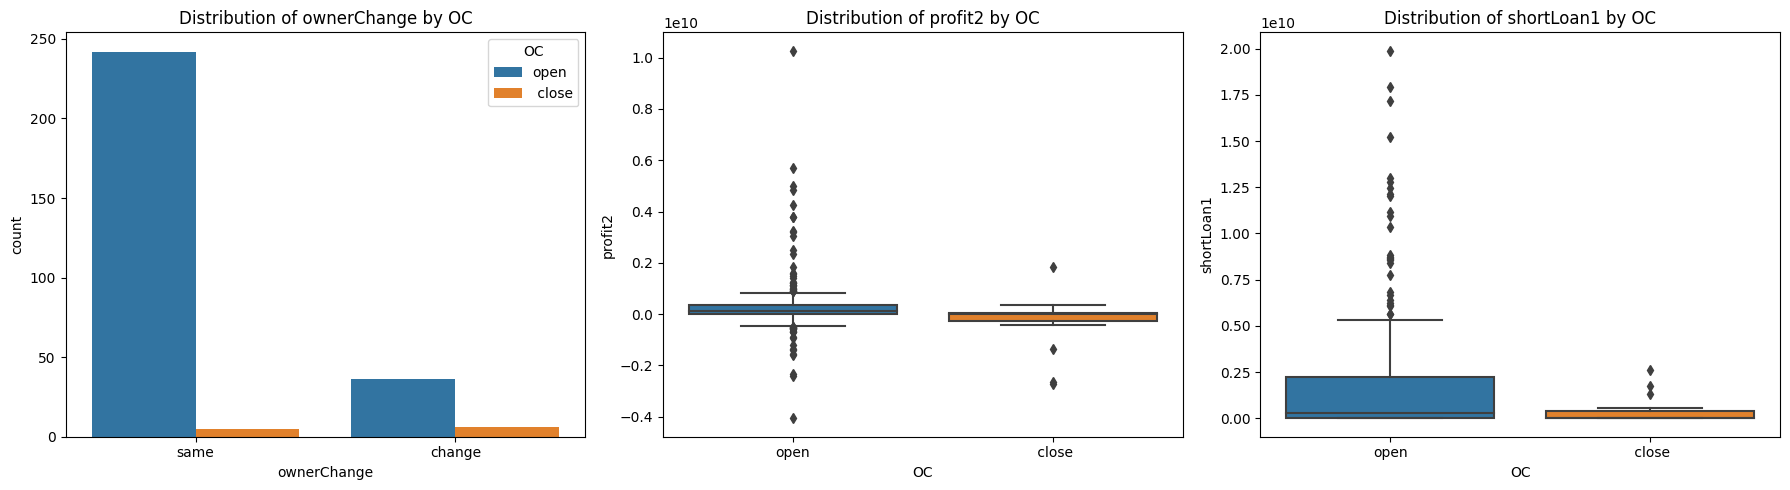

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 설정
plt.figure(figsize=(18, 5))

# ownerChange 분포
plt.subplot(1, 3, 1)
sns.countplot(data=data, x='ownerChange', hue='OC')
plt.title('Distribution of ownerChange by OC')

# profit2 분포
plt.subplot(1, 3, 2)
sns.boxplot(data=data, x='OC', y='profit2')
plt.title('Distribution of profit2 by OC')

# shortLoan1 분포
plt.subplot(1, 3, 3)
sns.boxplot(data=data, x='OC', y='shortLoan1')
plt.title('Distribution of shortLoan1 by OC')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 피처와 타겟 변수 분리
X = data.drop(['OC', 'inst_id'], axis=1)  # inst_id는 식별자이므로 제외
y = data['OC']

# 랜덤 포레스트 모델 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# 변수 중요도 추출 및 정렬
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importances.head(10)  # 상위 10개 중요 변수만 표시


In [ ]:
# 상위 10개 중요 변수 선택
top_features = feature_importances['feature'].head(10)

# 상위 중요 변수들 간의 상관 관계 계산
correlation_top_features = data[top_features].corr()

# 상관 관계 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_top_features, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Top Important Features')
plt.show()


In [ ]:
# 산점도 행렬 (scatter matrix) 생성
selected_features = ['profit1', 'profit2', 'bedCount', 'OC']
sns.pairplot(data[selected_features], hue='OC', diag_kind='kde', markers=['o', 's'])
plt.suptitle('Scatter Matrix of Selected Features', y=1.02)
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 데이터 스케일링
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.drop(['OC', 'inst_id'], axis=1))

# K-평균 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)  # 3개의 클러스터로 분류
data['cluster'] = kmeans.fit_predict(scaled_data)

# 각 클러스터 내에서의 개폐업 상태 분포 확인
cluster_oc_distribution = data.groupby('cluster')['OC'].value_counts().unstack().fillna(0)

cluster_oc_distribution
